In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import pytorch_lightning as pl, logging
# logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [2]:
class RBM(nn.Module):
    def __init__(self, n, alpha):
        super(RBM, self).__init__()
        self.l1 = nn.Linear(n, n*alpha)

    def forward(self, x):
        y = self.l1(x)
        return y, torch.exp(torch.sum(torch.log(2 * torch.cosh(y)), 1))

def normalize(y):
    return torch.div(y, torch.norm(y, p=2))

def dec_to_bin(x, y):  # converts a digit to a binary with y entrees
    return format(x, "0{0}b".format(y))

def neutral_states(n):  # gives all spin convigurations of n spins with total spin 0
    states = np.zeros([2**n, n], dtype=np.float64)
    for i in range(0, 2**n, 1):
        for j in range(0, n, 1):
            states[i, j] = 2 * int(dec_to_bin(i, n)[j]) - 1
    neutral_states = np.empty([0, n], dtype=np.float64)
    for i in range(0, 2**n, 1):
        if sum(states[i, :]) == 0:
            neutral_states = np.vstack((neutral_states, states[i,:]))
    return neutral_states

In [3]:
# hyperparameter
alpha = 1
n = 16
device = 'cuda'
dtype = torch.float64

In [4]:
# read files
# with open('optimized_W/alpha={0}/b.csv'.format(alpha), 'r') as file:
#     biases = np.loadtxt(file, delimiter=",", dtype=np.float64)

# with open('optimized_W/alpha={0}/W.csv'.format(alpha), 'r') as file:
#     weights = np.loadtxt(file, delimiter=",", dtype=np.float64).transpose()

# with open('ED_amplitude.csv', 'r') as file:
#     true_wf = np.loadtxt(file, delimiter=",", dtype=np.float64)
    

rbm = RBM(n, alpha).to(device)
# sd = rbm.state_dict()
# sd['l1.weight'] = torch.Tensor(weights)
# sd['l1.bias'] = torch.Tensor(biases)
rbm.load_state_dict(torch.load('../models/pytorch_model_a1.pkl'))

states = torch.Tensor(neutral_states(n)).to(device)

with torch.no_grad():
    hidden, output = rbm.forward(states)
    
output = normalize(output)

In [5]:
class CoshApprox(nn.Module):
    def __init__(self, n_in, n_hiddens):
        super(CoshApprox, self).__init__()
        
        ls = []
        for n_hidden in n_hiddens:
            ls.append( nn.Linear(n_in, n_hidden) )
            ls.append(nn.ReLU())
            n_in = n_hidden
        ls.append( nn.Linear(n_in, 1) )

        self.layers = nn.Sequential(*ls)
        
    def forward(self, x):
        return self.layers(x)
    
class LitCosh(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = torch.nn.functional.mse_loss(out, y)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    def test_step(self, batch):
        x, y = batch
        out = self.model(x)
        loss = torch.nn.functional.mse_loss(out, y)
        return loss
        
cosh_approx = CoshApprox(n, [30, 30, 30, 30])
model = LitCosh(cosh_approx).to(device)
dataset = list(zip(hidden, output.reshape(-1, 1) * 1e3))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256)
trainer = pl.Trainer(max_epochs=100, accelerator=device)
trainer.fit(model, dataloader)
res = model.model(hidden.to('cpu')).detach().numpy()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | CoshApprox | 3.3 K 
-------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.013     Total estimated model params size (MB)
c:\Users\lexj1\Documents\RU\NMC\project\NeuromorPhysics\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


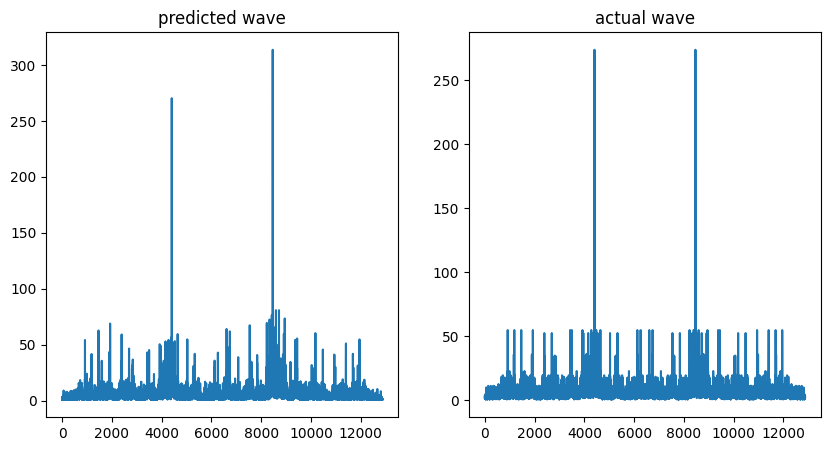

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(res)
ax[1].plot(output.to('cpu').detach().numpy()*1e3)
ax[0].set_title("predicted wave")
ax[1].set_title("actual wave")
plt.show()

# Find optimal model

In [14]:
def benchmark(n_in, n_layers, n_hidden, dataset, epochs, model, iterations=500, device='mps'):
    layers = [n_hidden for _ in range(n_layers)]
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256)

    trainer = pl.Trainer(max_epochs=epochs, accelerator=device, enable_model_summary=False, enable_checkpointing=False)
    
    avg_loss = 0
    for _ in range(iterations):
        cosh_approx = CoshApprox(n_in, layers)
        model = LitCosh(cosh_approx).to(device)
        trainer.fit(model, dataloader)
    
        loss = model.to(device).test_step((hidden.to(device), output.to(device)))
        avg_loss += loss
        
    return avg_loss/iterations

Training: 0it [00:00, ?it/s]

C:\Users\lexj1\AppData\Local\Temp\ipykernel_9220\3246806978.py:35: UserWarning: Using a target size (torch.Size([12870])) that is different to the input size (torch.Size([12870, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(out, y)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

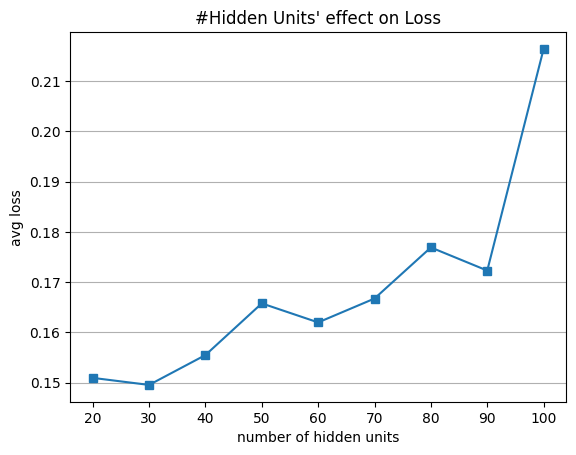

In [16]:
# optimal n_hidden on 2 layers trained over 20 epochs:
epochs = 50
n_layers = 2
n_hiddens = [20, 30, 40, 50, 60, 70, 80, 90, 100]
losses = np.zeros(len(n_hiddens))

dataset = list(zip(hidden, output.reshape(-1, 1) * 1e3))
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

for idx, n_hidden in enumerate(n_hiddens):
    losses[idx] = benchmark(n, n_layers, n_hidden, dataset, epochs, model, device='cuda')
    
    
plt.plot(n_hiddens, losses, marker='s')

plt.xlabel('number of hidden units')
plt.ylabel('avg loss')
plt.title("#Hidden Units' effect on Loss")
plt.grid(axis='y')
plt.show()

c:\Users\lexj1\Documents\RU\NMC\project\NeuromorPhysics\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

C:\Users\lexj1\AppData\Local\Temp\ipykernel_9220\3246806978.py:35: UserWarning: Using a target size (torch.Size([12870])) that is different to the input size (torch.Size([12870, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(out, y)


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

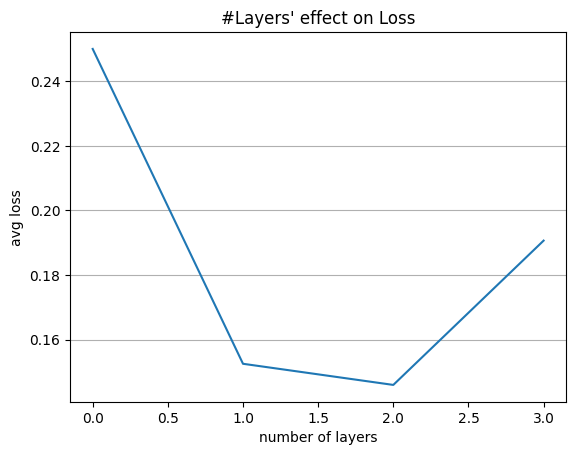

In [21]:
# optimal n_layers on optimal n_hidden found above over 20 epochs:
epochs = 50
n_hidden = 30  # fixme
n_layers = np.arange(1, 5)
losses = np.zeros(len(n_layers))

for idx, layer_size in enumerate(n_layers):
    losses[idx] = benchmark(n, layer_size, n_hidden, dataset, epochs, model, device='cuda')
    
plt.plot(losses)

plt.xlabel('number of layers')
plt.ylabel('avg loss')
plt.title("#Layers' effect on Loss")
plt.grid(axis='y')
plt.show()

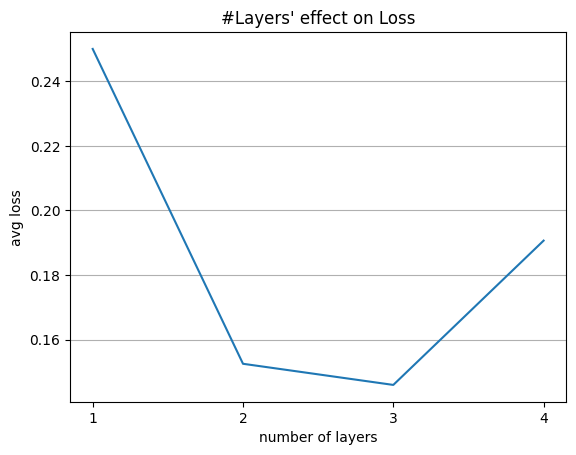

In [30]:
plt.plot(n_layers, losses)

plt.xlabel('number of layers')
plt.ylabel('avg loss')
plt.xticks(np.arange(1, 5, step=1))
plt.title("#Layers' effect on Loss")
plt.grid(axis='y')
plt.show()

# Save Best Model

c:\Users\lexj1\Documents\RU\NMC\project\NeuromorPhysics\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

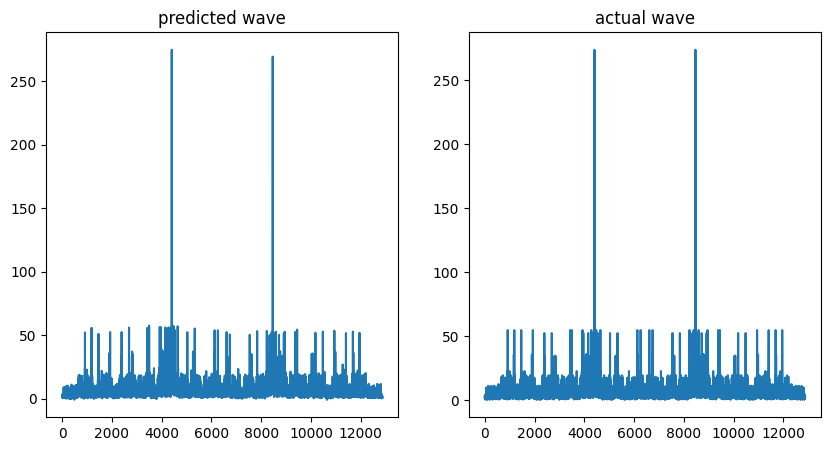

In [31]:
model = LitCosh(CoshApprox(n, [30, 30, 30])).to(device)
dataset = list(zip(hidden, output.reshape(-1, 1) * 1e3))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256)
trainer = pl.Trainer(max_epochs=500, accelerator=device)
trainer.fit(model, dataloader)
res = model.model(hidden.to('cpu')).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(res)
ax[1].plot(output.to('cpu').detach().numpy()*1e3)
ax[0].set_title("predicted wave")
ax[1].set_title("actual wave")
plt.show()

# save model
torch.save(model.model.state_dict(), '../models/wave_model.pkl')

In [33]:
model.to(device).test_step((hidden.to(device), output.to(device))).cpu().detach().numpy()

C:\Users\lexj1\AppData\Local\Temp\ipykernel_9220\3246806978.py:35: UserWarning: Using a target size (torch.Size([12870])) that is different to the input size (torch.Size([12870, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(out, y)


array(79.91556, dtype=float32)

# rescale parameters

In [ ]:
# final best model:
cosh_approx = CoshApprox(n, [50, 50, 50])
model = LitCosh(cosh_approx).to(device)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
trainer = pl.Trainer(max_epochs=100, accelerator=device)
trainer.fit(model, dataloader)

In [ ]:
# FIXME: unlikely to work
# rescale

sd = model.state_dict()
sd['nn_layers'] /= 1e3
model.load_state_dict(sd)
res = model.model(hidden.to('cpu')).detach().numpy()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(res)
ax[1].plot(output.to('cpu').detach().numpy()*1e3)
ax[0].set_title("predicted wave")
ax[1].set_title("actual wave")
plt.show()